In [20]:
import pmdarima as pm
import pandas as pd
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import matplotlib.pyplot as plt
from pmdarima.arima import ndiffs
import numpy as np
from sklearn.metrics import mean_squared_error
from tqdm import tqdm


In [2]:
y_train = pd.read_csv('dataset/y_train.csv').set_index('DELIVERY_START')
y_train.index = pd.to_datetime(y_train.index, utc=True).tz_convert(None)

# fix outliers
y_train.loc["2022-04-04 05:00:00"] = (y_train.loc["2022-04-04 04:00:00"] + y_train.loc["2022-04-04 07:00:00"]) / 2
y_train.loc["2022-04-04 06:00:00"] = (y_train.loc["2022-04-04 04:00:00"] + y_train.loc["2022-04-04 07:00:00"]) / 2
y_train.head()

,spot_id_delta
DELIVERY_START,
2022-01-01 01:00:00,-36.874770
2022-01-01 02:00:00,-12.643588
2022-01-01 03:00:00,-1.950193
2022-01-01 04:00:00,1.938272
2022-01-01 05:00:00,0.199907


In [13]:
y_train.dtypes

spot_id_delta    float64
dtype: object

<Axes: xlabel='DELIVERY_START'>

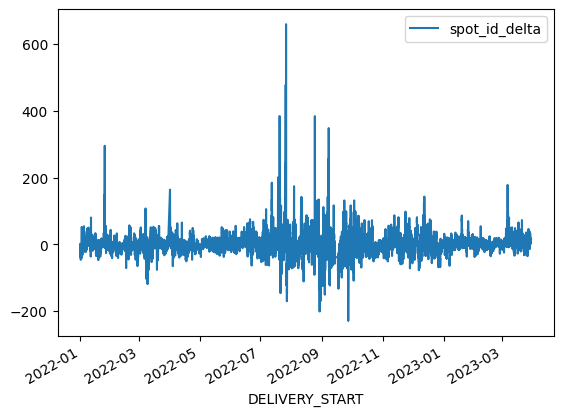

In [3]:
y_train.plot()

In [4]:
type(y_train.values)

numpy.ndarray

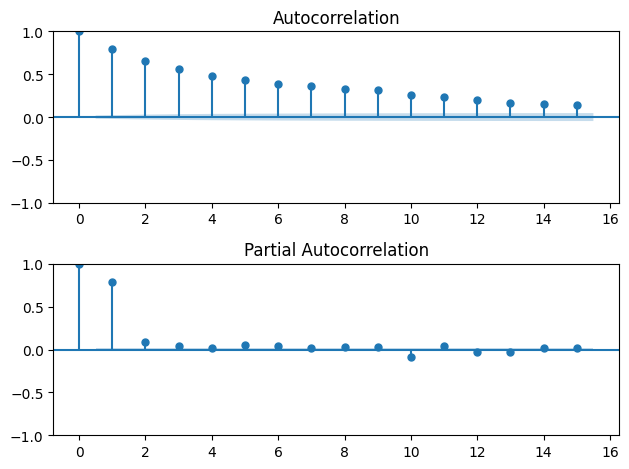

In [5]:
lag = 15
f, ax = plt.subplots(nrows=2, ncols=1)
plot_acf(y_train.values, lags=lag, ax=ax[0])
plot_pacf(y_train.values,lags=lag, ax=ax[1], method='ols')
plt.tight_layout()
plt.show()

In [6]:
kpss_diffs = ndiffs(y_train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(y_train, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"Estimated differencing term: {n_diffs}")

Estimated differencing term: 0


### Train-test split

In [22]:
cutoff_date = "2023-03-01"
train = y_train.loc[:cutoff_date].values
test = y_train.loc[cutoff_date:].values

In [23]:
auto = pm.auto_arima(train, d=0, seasonal=False, stepwise=True, suppress_warnings=True, error_action="ignore", max_p=6,
                     max_order=None, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=87523.080, Time=1.50 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=97395.177, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=87653.140, Time=0.17 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=91792.557, Time=0.47 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=87545.656, Time=0.60 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=87523.036, Time=0.88 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=87561.526, Time=0.35 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=87571.349, Time=0.30 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=87522.989, Time=1.86 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=87553.292, Time=0.21 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=87557.083, Time=0.40 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=87517.451, Time=2.40 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=87516.981, Time=3.56 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=87510.419, Time=4.22 sec
 ARIMA(5,0,1)(0,0,0

In [24]:
def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

Q: is it realistic that we have access to new true value in each time step?

In [25]:
model = auto
forecasts = []
confidence_intervals = []

for new_ob in tqdm(test):
    fc, conf = forecast_one_step()
    forecasts.append(fc)
    confidence_intervals.append(conf)

    # Updates the existing model with a small number of MLE steps
    model.update(new_ob)

print(f"Mean squared error: {mean_squared_error(test, forecasts)}")

100%|██████████| 694/694 [05:51<00:00,  1.97it/s]

Mean squared error: 131.30744685751807


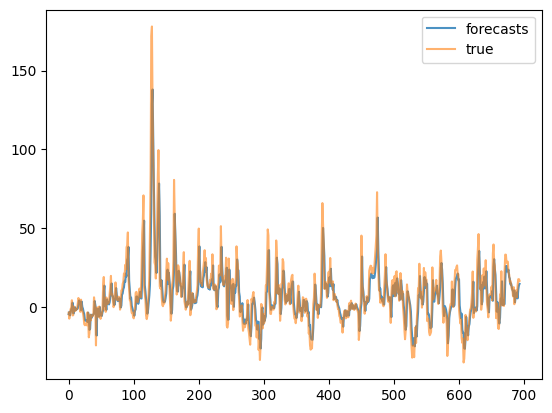

In [35]:
plt.plot(forecasts, alpha=0.8, label="forecasts")
plt.plot(test, alpha=0.6, label="true")
plt.legend()